In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import geopandas as gpd
from rasterio.enums import Resampling
import dask.array as da
import pathlib
import os
from geocube.api.core import make_geocube
import joblib
from joblib import Parallel, delayed
%config InlineBackend.figure_format = 'retina'

先计算河流风险

In [2]:
buffer_stage_1 = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\BUFFER\buffer_stage_1.tif").squeeze("band",drop=True)
buffer_stage_1

<xarray.Dataset>
Dimensions:      (x: 1560, y: 1800)
Coordinates:
  * x            (x) float64 110.0 110.0 110.0 110.0 ... 123.0 123.0 123.0 123.0
  * y            (y) float64 43.18 43.17 43.16 43.16 ... 28.03 28.02 28.01 28.0
    spatial_ref  int32 ...
Data variables:
    band_data    (y, x) float32 ...

In [3]:
buffer_stage_2 = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\BUFFER\buffer_stage_2.tif").squeeze("band",drop=True)
buffer_stage_2

<xarray.Dataset>
Dimensions:      (x: 1560, y: 1800)
Coordinates:
  * x            (x) float64 110.0 110.0 110.0 110.0 ... 123.0 123.0 123.0 123.0
  * y            (y) float64 43.18 43.17 43.16 43.16 ... 28.03 28.02 28.01 28.0
    spatial_ref  int32 ...
Data variables:
    band_data    (y, x) float32 ...

In [4]:
buffer_stage_1_frame = buffer_stage_1.band_data
buffer_stage_2_frame = buffer_stage_2.band_data

In [5]:
river_risk_seq = np.zeros_like(buffer_stage_1_frame)
river_risk_seq[:] = 0.5
river_risk_seq[buffer_stage_1_frame == 1] = 0.9
river_risk_seq[buffer_stage_2_frame == 2] = 0.8


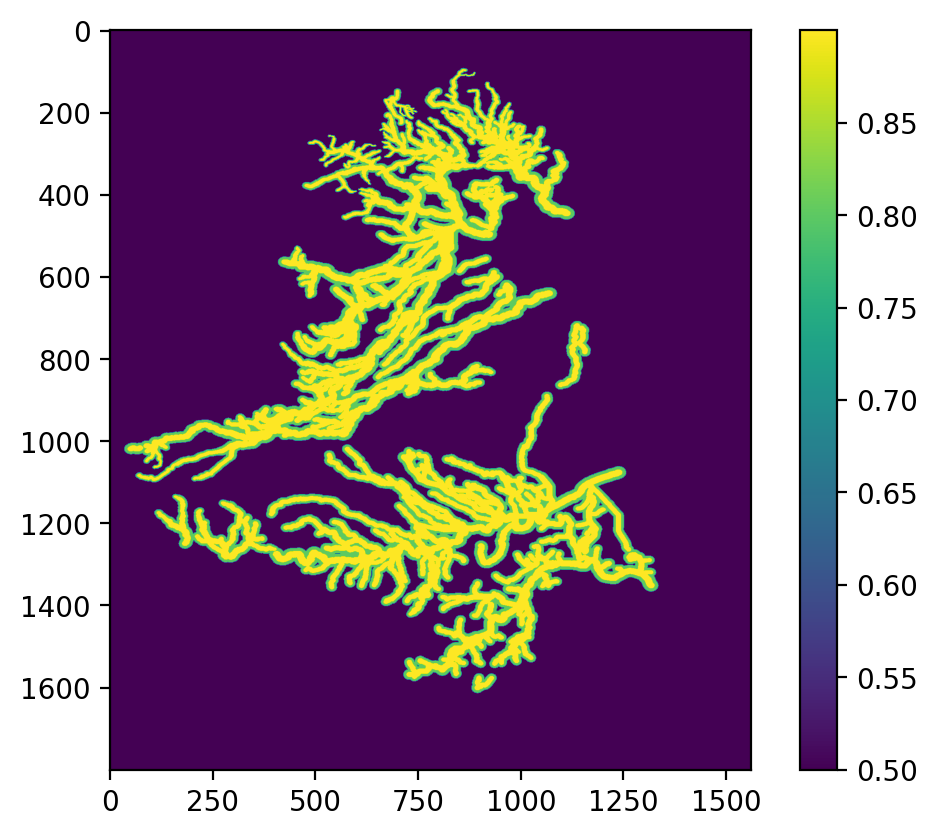

In [6]:
plt.imshow(river_risk_seq)
plt.colorbar()

In [7]:
river_risk_frame = xr.DataArray(river_risk_seq, dims=buffer_stage_1_frame.dims, coords=buffer_stage_1_frame.coords, name="band_data")
river_risk_frame.rio.write_transform(buffer_stage_1.rio.transform(),inplace=True)

<xarray.DataArray 'band_data' (y: 1800, x: 1560)>
array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], dtype=float32)
Coordinates:
  * x            (x) float64 110.0 110.0 110.0 110.0 ... 123.0 123.0 123.0 123.0
  * y            (y) float64 43.18 43.17 43.16 43.16 ... 28.03 28.02 28.01 28.0
    spatial_ref  int32 ...

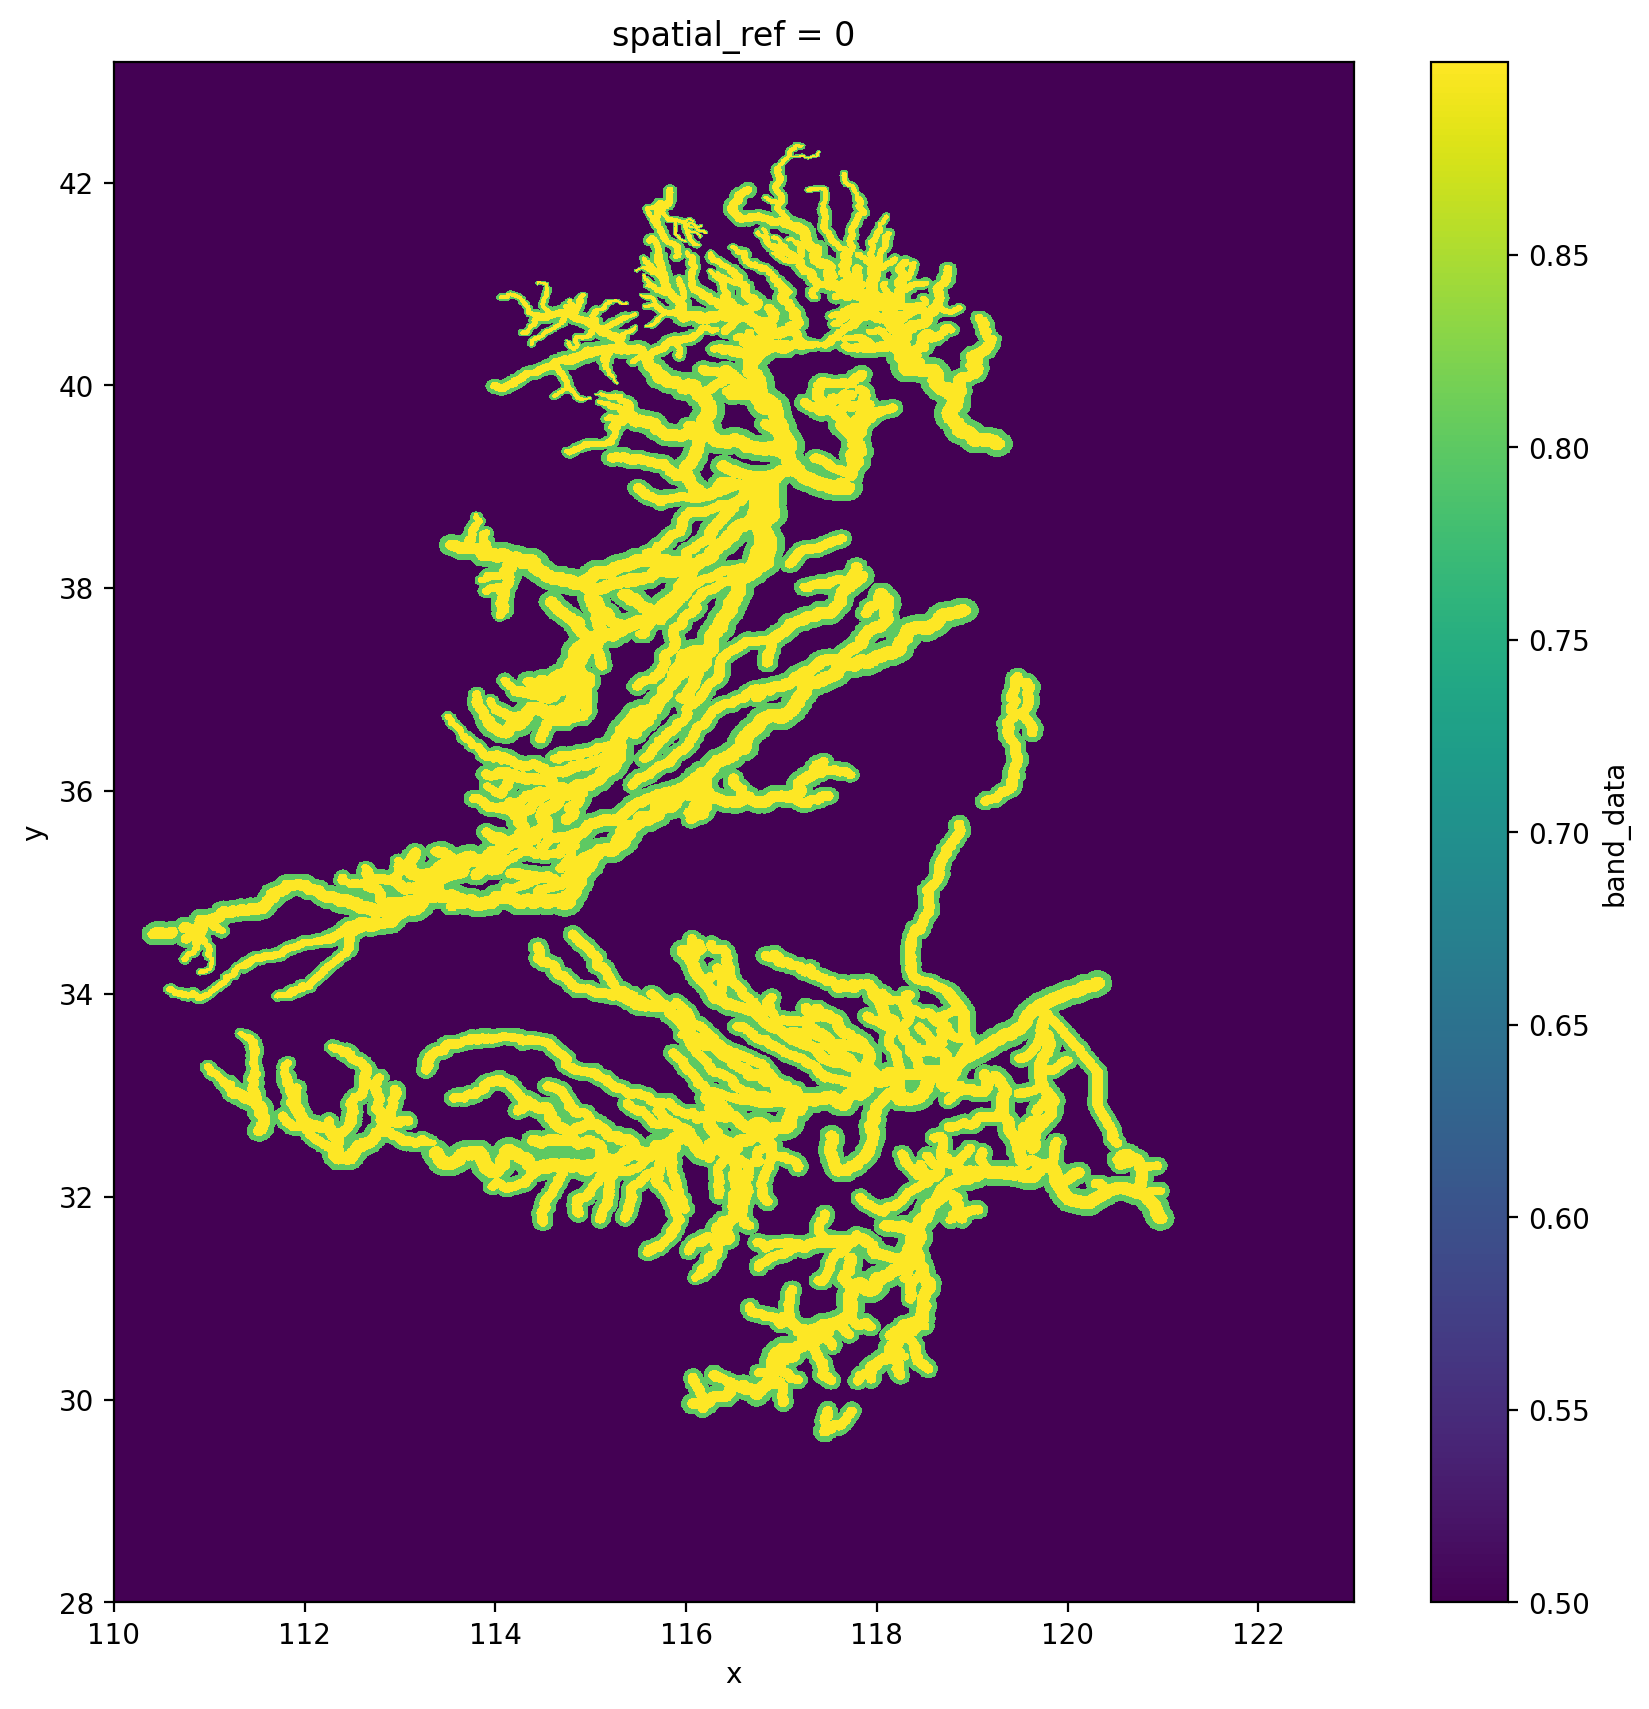

In [8]:
fig,ax = plt.subplots(figsize=(10,10))
river_risk_frame.plot(ax=ax)

河流风险计算完成，计算地形因素

In [9]:
dem_set = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\DEM-90\DEM_SRTM.nc",decode_coords="all")
dem_set = dem_set.rio.reproject_match(river_risk_frame)

c:\Users\zyzh0\miniforge3\envs\gis\lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
c:\Users\zyzh0\miniforge3\envs\gis\lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [10]:
dem_std_set = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\DEM-90\DEM_SRTM_std.tif").squeeze("band",drop=True)
dem_std_set = dem_std_set.rio.reproject_match(river_risk_frame)

In [11]:
dem_frame = dem_set.band_data.to_numpy()
dem_std_frame = dem_std_set.band_data.to_numpy()

In [12]:
dem_levels = np.array([np.nanmin(dem_frame),180,420,790,1220,np.max(dem_frame)])
dem_std_levels = np.array([np.nanmin(dem_std_frame),13.9,40.3,np.nanmax(dem_std_frame)])

In [13]:
((dem_frame < dem_levels[0])*(dem_std_frame<dem_std_levels[0])).shape

(1800, 1560)

In [14]:
terrain_risk_seq = np.zeros_like(dem_frame)

for i in range(len(dem_std_levels)-1):
    for j in range(len(dem_levels)-1):
        dem = dem_levels[j]
        dem_next = dem_levels[j+1]
        dem_std = dem_std_levels[i]
        dem_std_next = dem_std_levels[i+1]

        risk_level = 0.9 - (j)*0.1 - (i)*0.1
        terrain_risk_seq[((dem<dem_frame)*(dem_frame<dem_next))*((dem_std<dem_std_frame)*(dem_std_frame<dem_std_next))]= risk_level

In [15]:
terrain_risk_frame = xr.DataArray(terrain_risk_seq, dims=dem_std_set.band_data.dims, coords=dem_std_set.band_data.coords, name="band_data")
terrain_risk_frame.rio.write_transform(dem_std_set.rio.transform(),inplace=True)
terrain_risk_frame

<xarray.DataArray 'band_data' (y: 1800, x: 1560)>
array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.7, 0.7, 0.8, ..., 0. , 0. , 0. ],
       [0.8, 0.7, 0.7, ..., 0. , 0. , 0. ],
       [0.8, 0.8, 0.8, ..., 0. , 0. , 0. ]], dtype=float32)
Coordinates:
  * x            (x) float64 110.0 110.0 110.0 110.0 ... 123.0 123.0 123.0 123.0
  * y            (y) float64 43.18 43.17 43.16 43.16 ... 28.03 28.02 28.01 28.0
    spatial_ref  int32 0

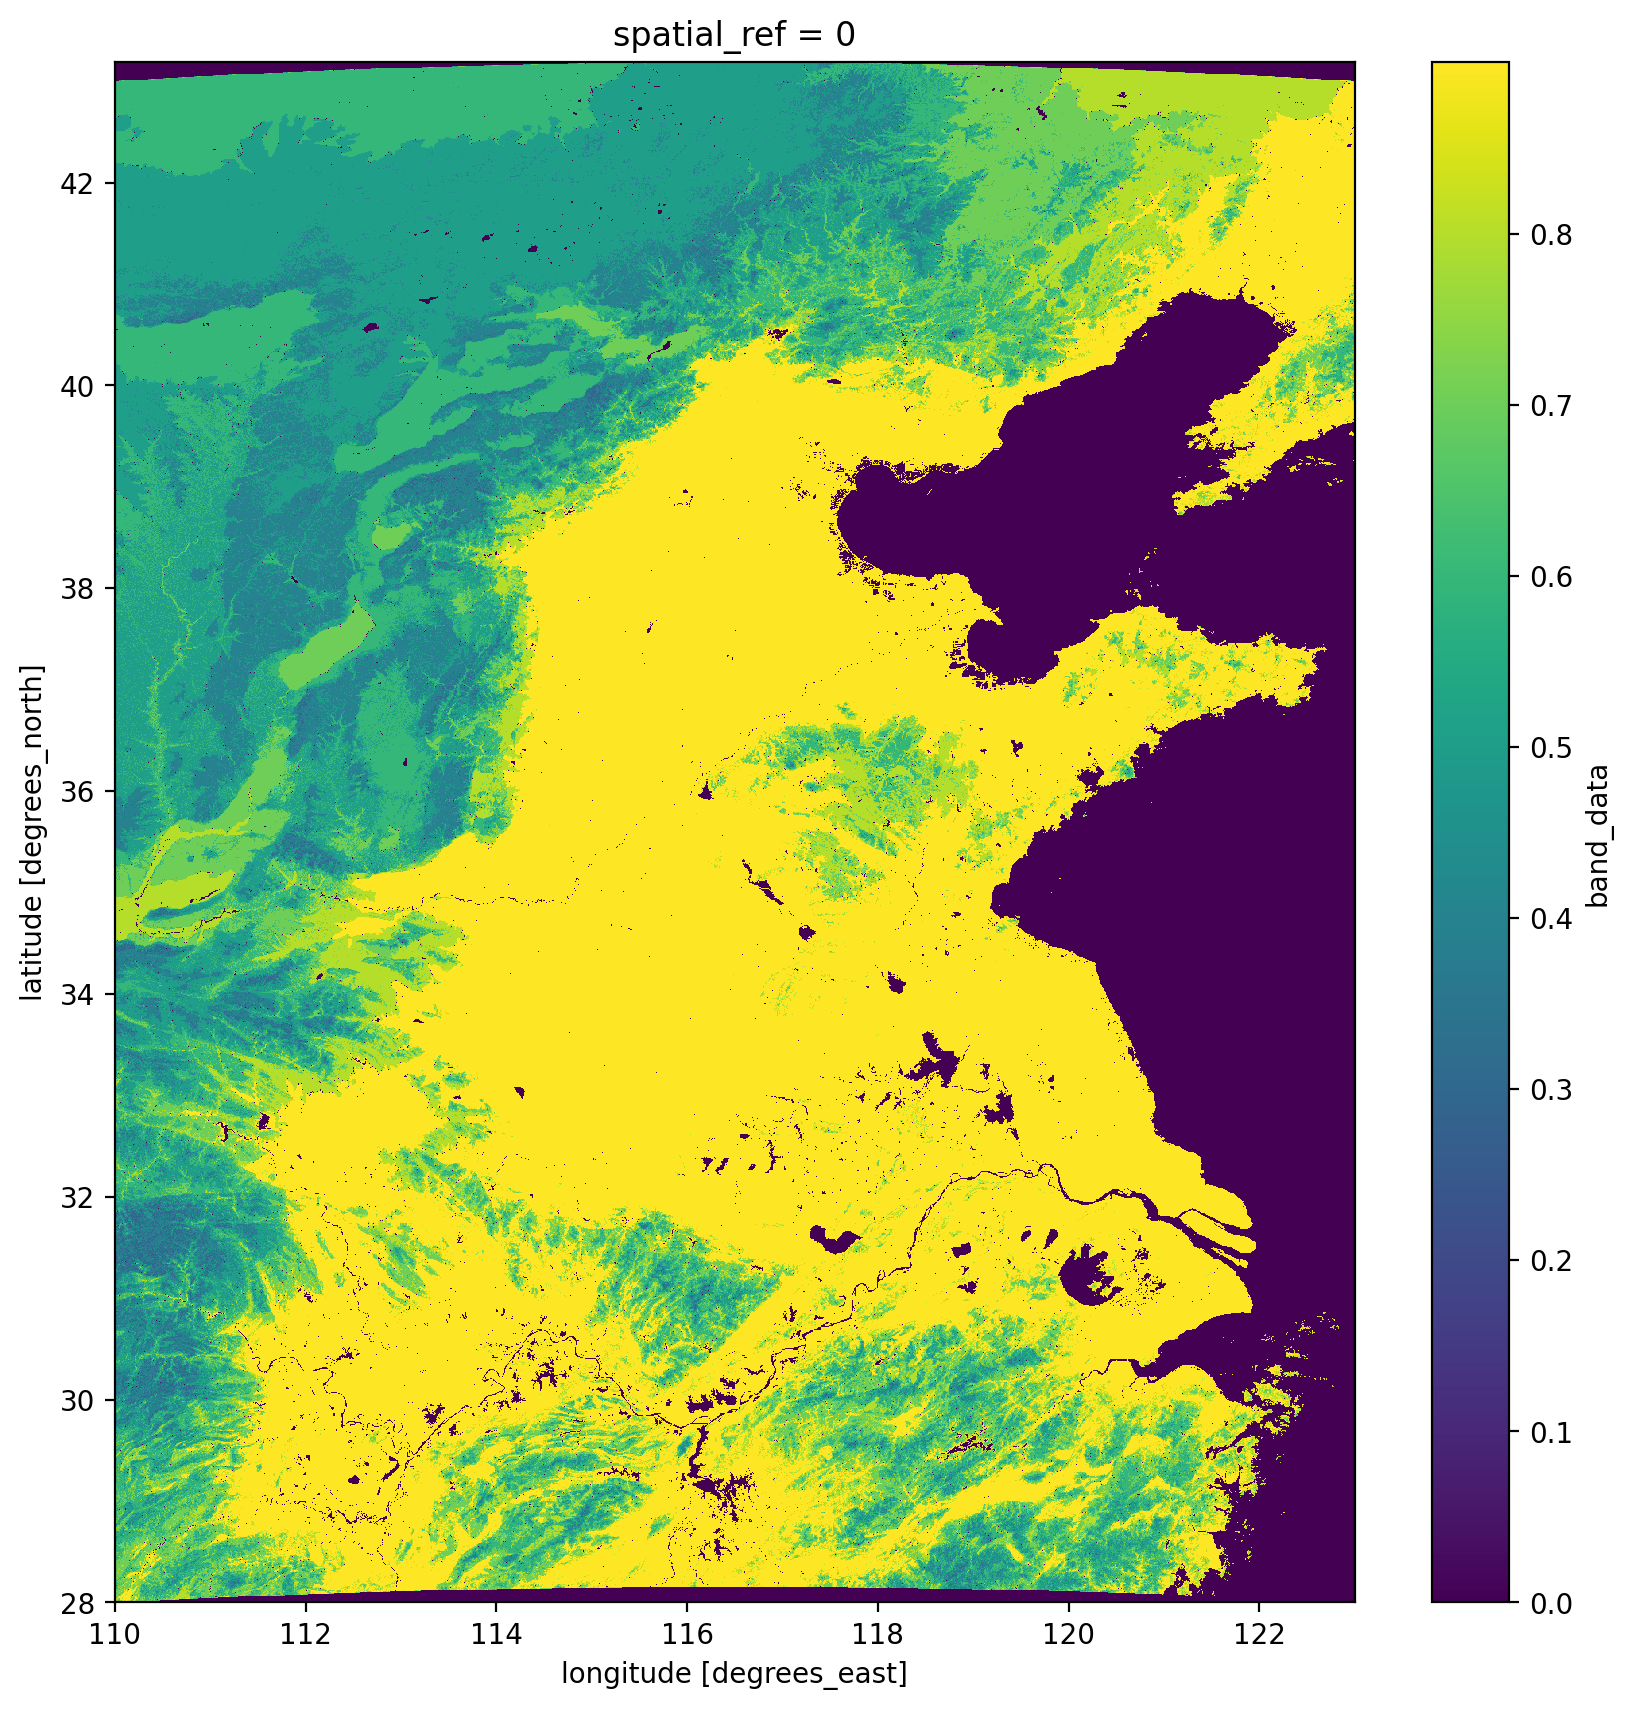

In [16]:
fig,ax = plt.subplots(figsize=(10,10))
terrain_risk_frame.plot(ax=ax)

地形风险计算完成，计算降水风险

In [17]:
gpd = gpd.read_file(r'E:\risk_evaluation\scripts\datas\BOARDER\extracted\华北平原地市级\华北平原地市级.shp')
gpd = gpd.dissolve()

In [18]:
def read_precip() -> np.ndarray:
    data_frame_list = []
    for i in ["pre_2000_2002.nc", "pre_2003_2005.nc", "pre_2006_2008.nc", "pre_2009_2011.nc", "pre_2012_2014.nc", "pre_2015_2017.nc"]:
        filename  = os.path.join(r"E:\risk_evaluation\scripts\outputs\PRECIP",i)
        data_frame = xr.open_dataset(filename,decode_coords="all")
        data_frame = data_frame.rename({"lon":"x","lat":"y"})
        data_frame = data_frame.rio.reproject_match(river_risk_frame,inplace=True)
        data_frame = data_frame.rio.clip(gpd.geometry.values,crs=gpd.crs,drop=True)
        data_frame = data_frame.to_array()[0,:,:,:]
        data_frame_list.append(data_frame)
    return np.concatenate(data_frame_list,axis=0)

In [19]:
precip_array_raw = read_precip()
precip_array_raw.shape

c:\Users\zyzh0\miniforge3\envs\gis\lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
c:\Users\zyzh0\miniforge3\envs\gis\lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
c:\Users\zyzh0\miniforge3\envs\gis\lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
c:\Users\zyzh0\miniforge3\envs\gis\lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
c:\Users\zyzh0\miniforge3\envs\gis\l

(216, 1567, 1482)

In [20]:
precip_avg_7_8 = []

for i in range(0,16):
    july_precip = precip_array_raw[i*12+6,:,:]
    august_precip = precip_array_raw[i*12+7,:,:]
    avg_precip = (july_precip+august_precip)/2
    precip_avg_7_8.append((avg_precip))

C:\Users\zyzh0\AppData\Local\Temp\ipykernel_108004\4230221199.py:6: RuntimeWarning: overflow encountered in add
  avg_precip = (july_precip+august_precip)/2


In [21]:
precip_avg_array = np.array(precip_avg_7_8)
precip_avg_array.shape

(16, 1567, 1482)

单位换算

In [22]:
precip_avg_array = precip_avg_array/10

这里的降水变率数据是裁剪过的

In [23]:
ref_frame = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\PRECIP\pre_2000_2002.nc",decode_coords="all")
ref_frame = ref_frame.rename({"lon":"x","lat":"y"})
ref_frame = ref_frame.rio.reproject_match(river_risk_frame,inplace=True)
ref_frame = ref_frame.rio.clip(gpd.geometry.values,crs=gpd.crs,drop=True)

c:\Users\zyzh0\miniforge3\envs\gis\lib\site-packages\rioxarray\raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


In [24]:
precip_var_set = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\PRECIP_VAR\pre_var.nc",decode_coords="all")
precip_var_set = precip_var_set.rio.reproject_match(ref_frame,inplace=True)
precip_var_set

<xarray.Dataset>
Dimensions:      (x: 1482, y: 1567, time: 16)
Coordinates:
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * time         (time) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    spatial_ref  int32 0
Data variables:
    pre_var      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

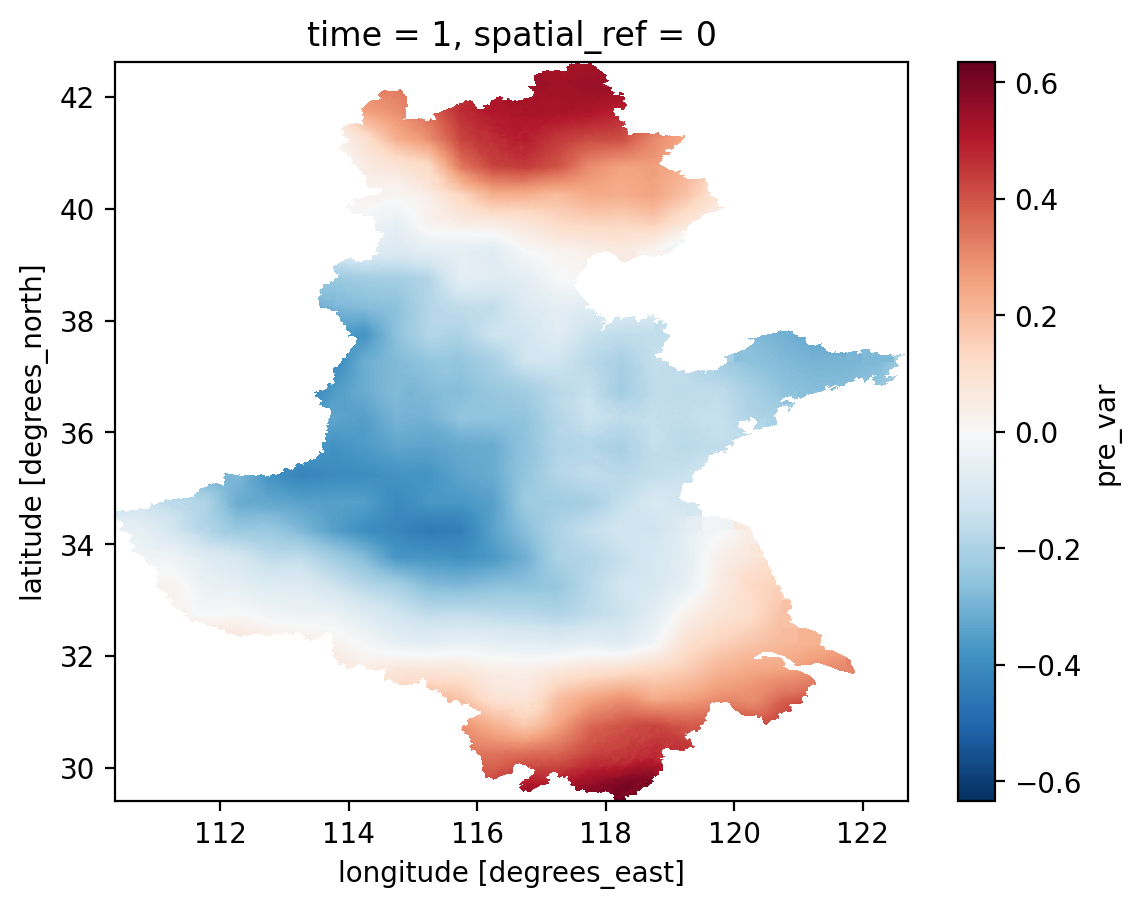

In [25]:
precip_var_set.loc[dict(time=1)].pre_var.plot()

降水变率要加绝对值（吗？）

In [26]:
precip_var_frame = precip_var_set.pre_var.to_numpy()
#precip_var_frame = np.abs(precip_var_frame)
precip_var_frame.shape

(16, 1567, 1482)

In [27]:
precip_avg_levels = np.array([np.nanmin(precip_avg_array),100,230,390,540,np.nanmax(precip_avg_array)])
precip_var_levels = np.array([np.nanmin(precip_var_frame),14.4/100,32.3/100,np.nanmax(precip_var_frame)])

In [28]:
np.nanmin(precip_avg_array)

37.55

In [29]:
np.nanmin(precip_var_frame)

-0.6551154

In [30]:
precip_risk_seq = np.zeros_like(precip_avg_array)


for i in range(len(precip_var_levels)-1):
    for j in range(len(precip_avg_levels)-1):
        precip_avg = precip_avg_levels[j]
        precip_avg_next = precip_avg_levels[j+1]
        precip_var = precip_var_levels[i]
        precip_var_next = precip_var_levels[i+1]

        risk_level = 0.3 + (j)*0.1 + (i)*0.1
        precip_risk_seq[((precip_avg<precip_avg_array)*(precip_avg_array<precip_avg_next))*((precip_var<precip_var_frame)*(precip_var_frame<precip_var_next))]= risk_level


In [31]:
np.unique(precip_risk_seq)

array([0. , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], dtype=float32)

In [32]:
precip_risk_frame = xr.DataArray(precip_risk_seq, dims=precip_var_set.pre_var.dims, coords=precip_var_set.pre_var.coords, name="band_data")
precip_risk_frame.rio.write_transform(precip_var_set.rio.transform(),inplace=True)
precip_risk_frame.rio.write_crs("EPSG:4326",inplace=True)
precip_risk_frame.rio.write_nodata(0,encoded=True,inplace=True)

<xarray.DataArray 'band_data' (time: 16, y: 1567, x: 1482)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * time         (time) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    spatial_ref  int32 0

In [33]:
precip_risk_frame.rio.nodata

nan

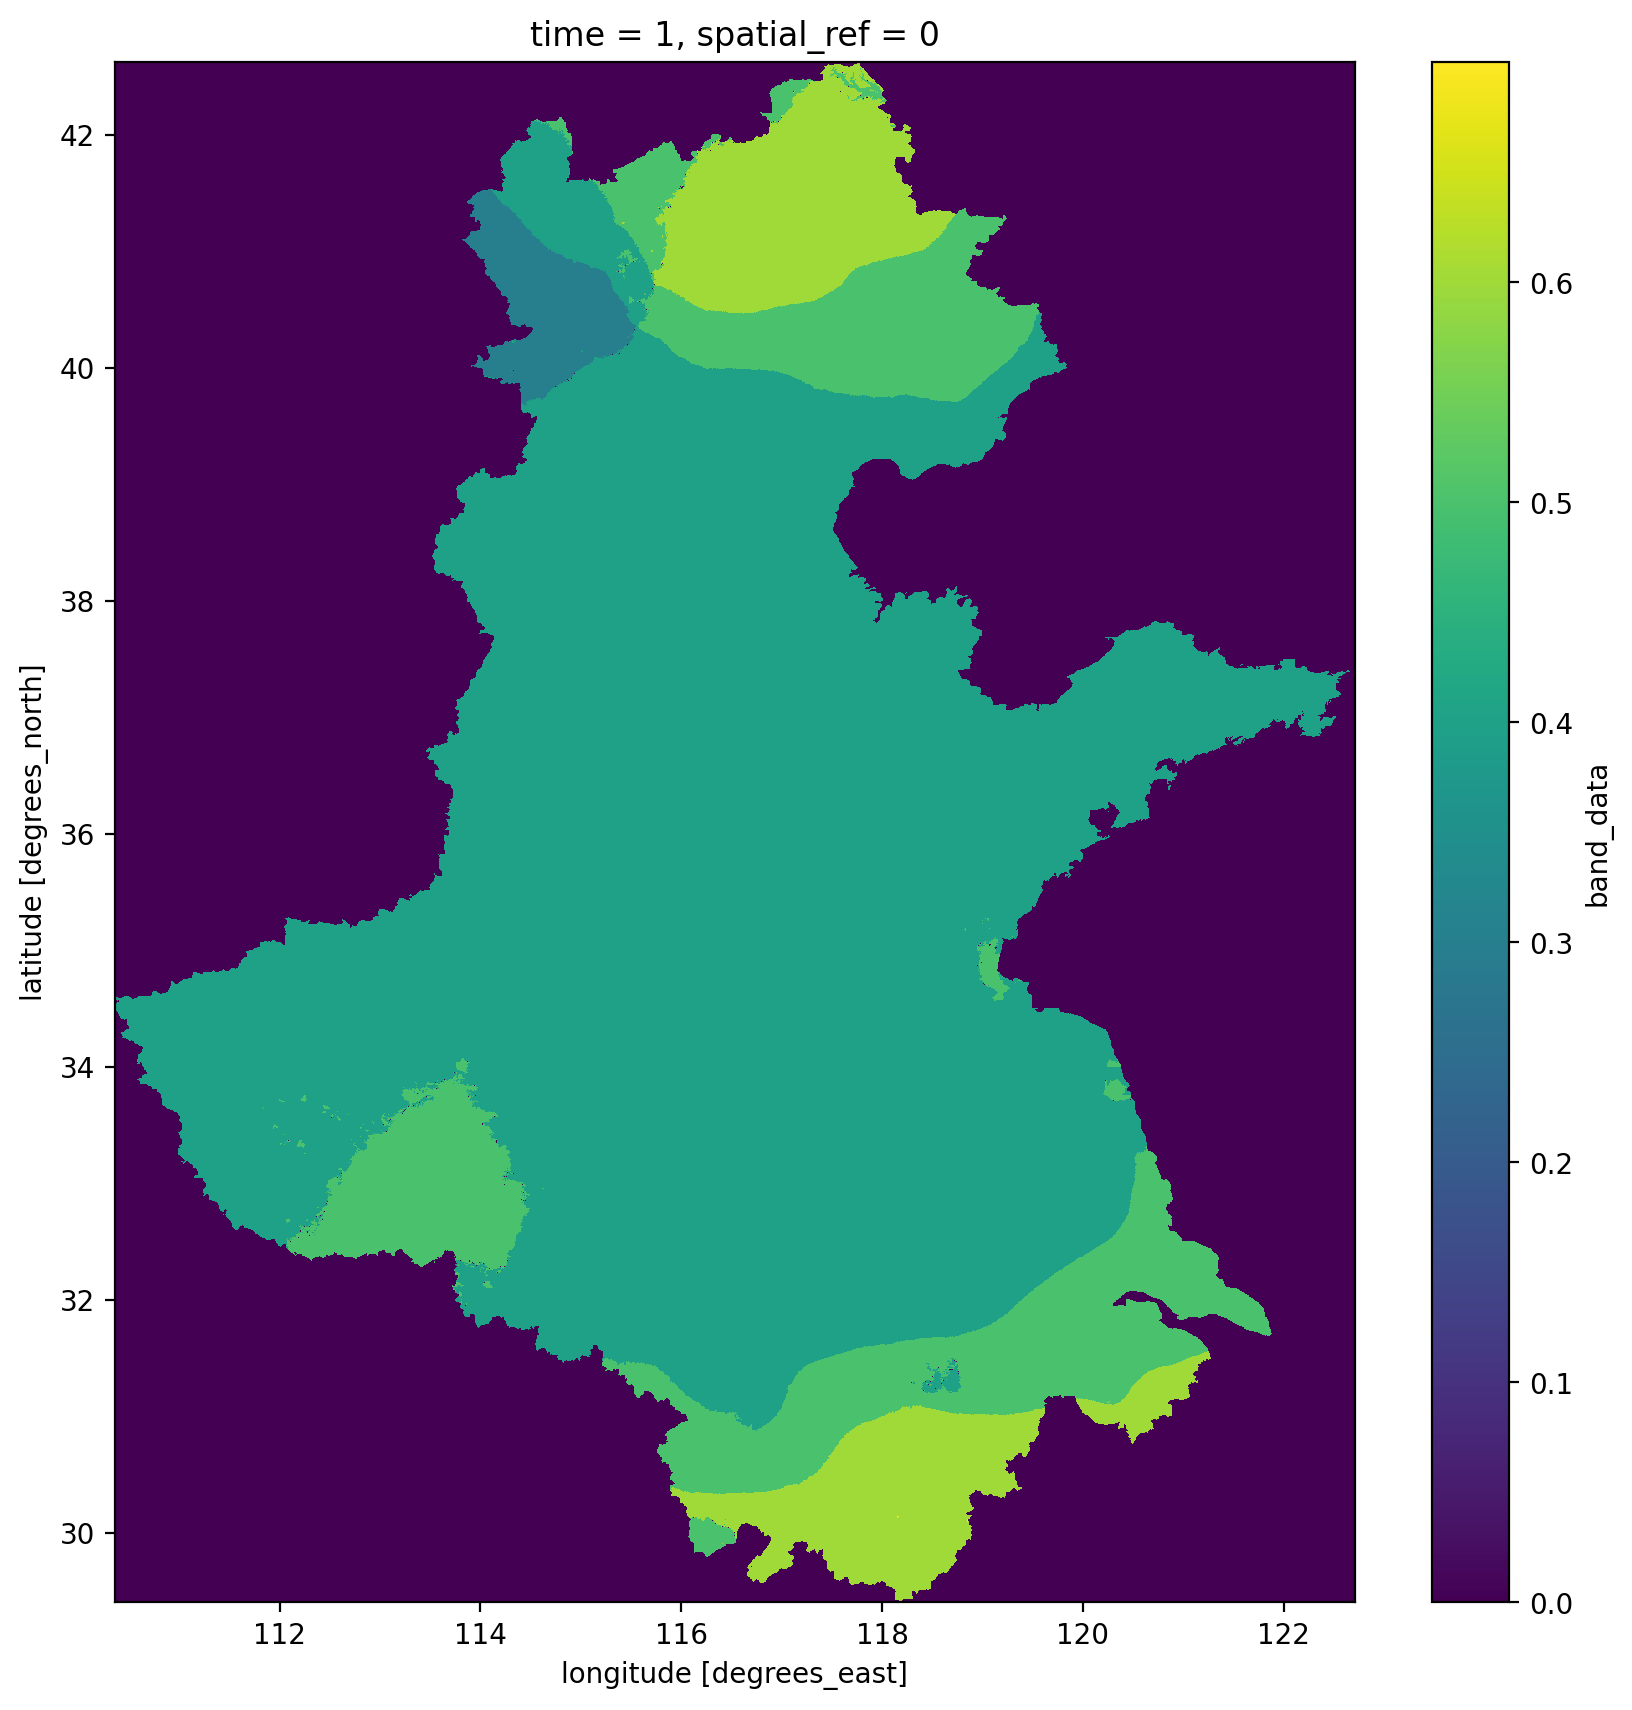

In [34]:
fig,ax = plt.subplots(figsize=(10,10))
precip_risk_frame.loc[{"time":1}].plot(ax=ax)

将上述计算的风险裁剪并叠加

In [35]:
river_risk_frame_clipped = river_risk_frame.rio.clip(gpd.geometry.values,crs=gpd.crs,drop=True)
river_risk_frame_clipped

<xarray.DataArray 'band_data' (y: 1567, x: 1482)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
    spatial_ref  int32 0

In [36]:
precip_risk_clipped_unmatch = precip_risk_frame.rio.clip(gpd.geometry.values,crs=gpd.crs,drop=True)
precip_risk_clipped = precip_risk_clipped_unmatch.rio.reproject_match(river_risk_frame_clipped)
precip_risk_clipped

<xarray.DataArray 'band_data' (time: 16, y: 1567, x: 1482)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * time         (time) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    spatial_ref  int32 0

In [37]:
terrain_risk_frame_clipped = terrain_risk_frame.rio.clip(gpd.geometry.values,crs=gpd.crs,drop=True)
terrain_risk_frame_clipped

<xarray.DataArray 'band_data' (y: 1567, x: 1482)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
    spatial_ref  int32 0

分析SPEI数据并统计干旱频次

In [38]:
spei_set = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\SPEI\spei.nc",decode_coords="all")
spei_set

<xarray.Dataset>
Dimensions:      (y: 1800, x: 1560, month: 192)
Coordinates:
  * y            (y) float64 28.0 28.01 28.02 28.03 ... 42.97 42.98 42.99 43.0
  * x            (x) float64 110.0 110.0 110.0 110.0 ... 123.0 123.0 123.0 123.0
  * month        (month) int32 1 2 3 4 5 6 7 8 ... 186 187 188 189 190 191 192
    spatial_ref  int32 ...
Data variables:
    spei         (month, y, x) float64 ...

In [39]:
spei_set_cutted = spei_set.rio.clip(gpd.geometry.values,crs=gpd.crs,drop=True)
spei_set_cutted = spei_set_cutted.rio.reproject_match(terrain_risk_frame_clipped)

In [40]:
spei_array = spei_set_cutted.spei.to_numpy()
spei_array.shape

(192, 1567, 1482)

In [41]:
drought_happend_array = spei_array < -0.5
dry_happend_array = spei_array > 0.5

In [42]:
drought_happend_array=drought_happend_array.astype(int)
dry_happend_array=dry_happend_array.astype(int)

In [43]:
drought_count_array = np.zeros_like(drought_happend_array[:16,:,:])
drought_count_array.shape

(16, 1567, 1482)

In [44]:
dry_count_array = np.zeros_like(dry_happend_array[:16,:,:])
dry_count_array.shape

(16, 1567, 1482)

In [45]:
for i in range(16):
    drought_count_array[i,:,:] = np.sum(drought_happend_array[i*12:i*12+12,:,:],axis=0)

In [46]:
for i in range(16):
    dry_count_array[i,:,:] = np.sum(dry_happend_array[i*12:i*12+12,:,:],axis=0)

In [47]:
flood_prob_array = drought_count_array/12/0.25
dry_prob_array = dry_count_array/12/0.25

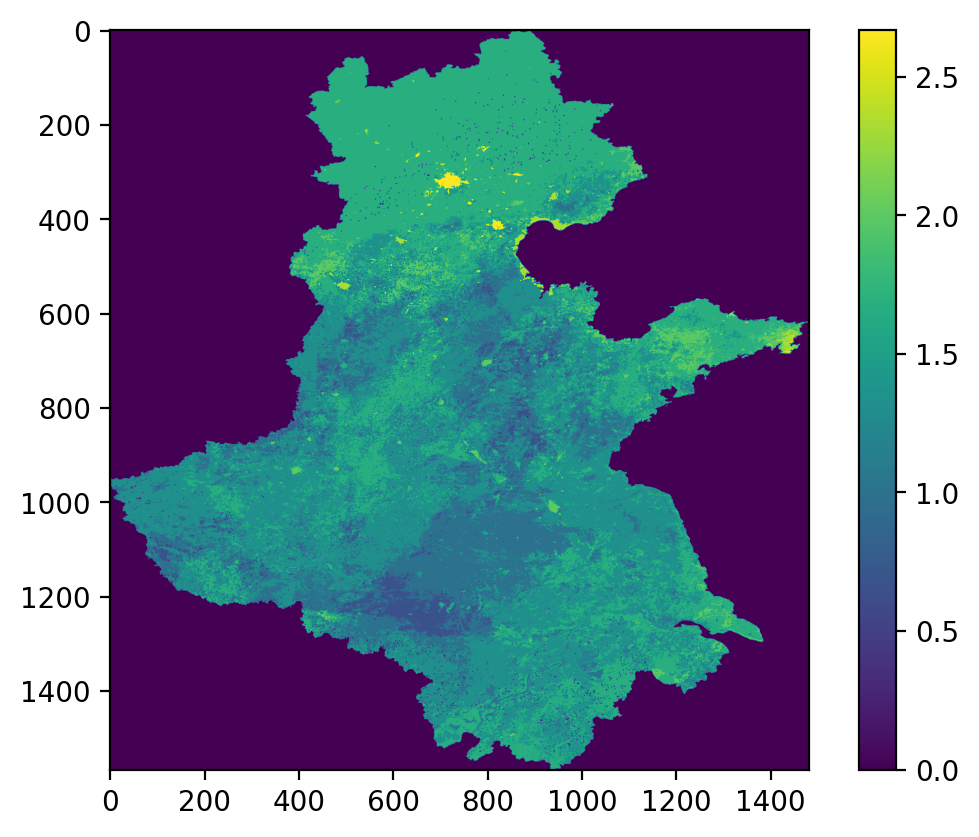

In [48]:
plt.imshow(flood_prob_array[5,:,:])
plt.colorbar()

使用层次分析法确定权重

In [49]:
river_weight = 0.1737
precip_weight = 0.3271
terrain_weight = 0.1038
dry_weight = 0.3954

In [50]:
total_drought_risk_array = (river_weight*river_risk_frame_clipped.to_numpy() + terrain_weight*terrain_risk_frame_clipped.to_numpy() + precip_weight*precip_risk_clipped.to_numpy()+dry_weight*dry_prob_array)/(river_weight+terrain_weight+precip_weight)
total_drought_risk_frame = xr.DataArray(total_drought_risk_array, dims=precip_risk_clipped.dims, coords=precip_risk_clipped.coords, name="band_data")
total_drought_risk_frame.rio.write_transform(precip_risk_clipped.rio.transform(),inplace=True)
total_drought_risk_frame.rio.write_crs("EPSG:4326",inplace=True)

<xarray.DataArray 'band_data' (time: 16, y: 1567, x: 1482)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * time         (time) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    spatial_ref  int32 0

计算总风险

In [51]:
total_risk_array = total_drought_risk_array*0.6+flood_prob_array*0.4

In [52]:
total_risk_set = xr.Dataset(
    {
        "total_risk": (["time", "y", "x"], total_risk_array),
    },
    coords={
        "time": [i for i in range(2000,2016)],
        "y": spei_set_cutted.y.data,
        "x": spei_set_cutted.x.data,
    },
)


In [53]:
total_risk_set.rio.write_crs("EPSG:4326",inplace=True)
total_risk_set.rio.write_transform(inplace=True)

<xarray.Dataset>
Dimensions:      (time: 16, y: 1567, x: 1482)
Coordinates:
  * time         (time) int32 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
    spatial_ref  int32 0
Data variables:
    total_risk   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [54]:
total_risk_set.to_netcdf(path=r"E:\risk_evaluation\scripts\outputs\RISK_PROB\risk_prob.nc")

OSError: [Errno 22] Invalid argument: 'E:\\risk_evaluation\\scripts\\outputs\\RISK_PROB\\risk_prob.nc'

In [ ]:
total_risk_set = xr.open_dataset(r"E:\risk_evaluation\scripts\outputs\RISK_PROB\risk_prob.nc")
total_risk_set

<xarray.Dataset>
Dimensions:      (y: 1567, x: 1482, time: 16)
Coordinates:
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
  * time         (time) int32 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
Data variables:
    total_risk   (time, y, x) float64 ...
    spatial_ref  int32 ...

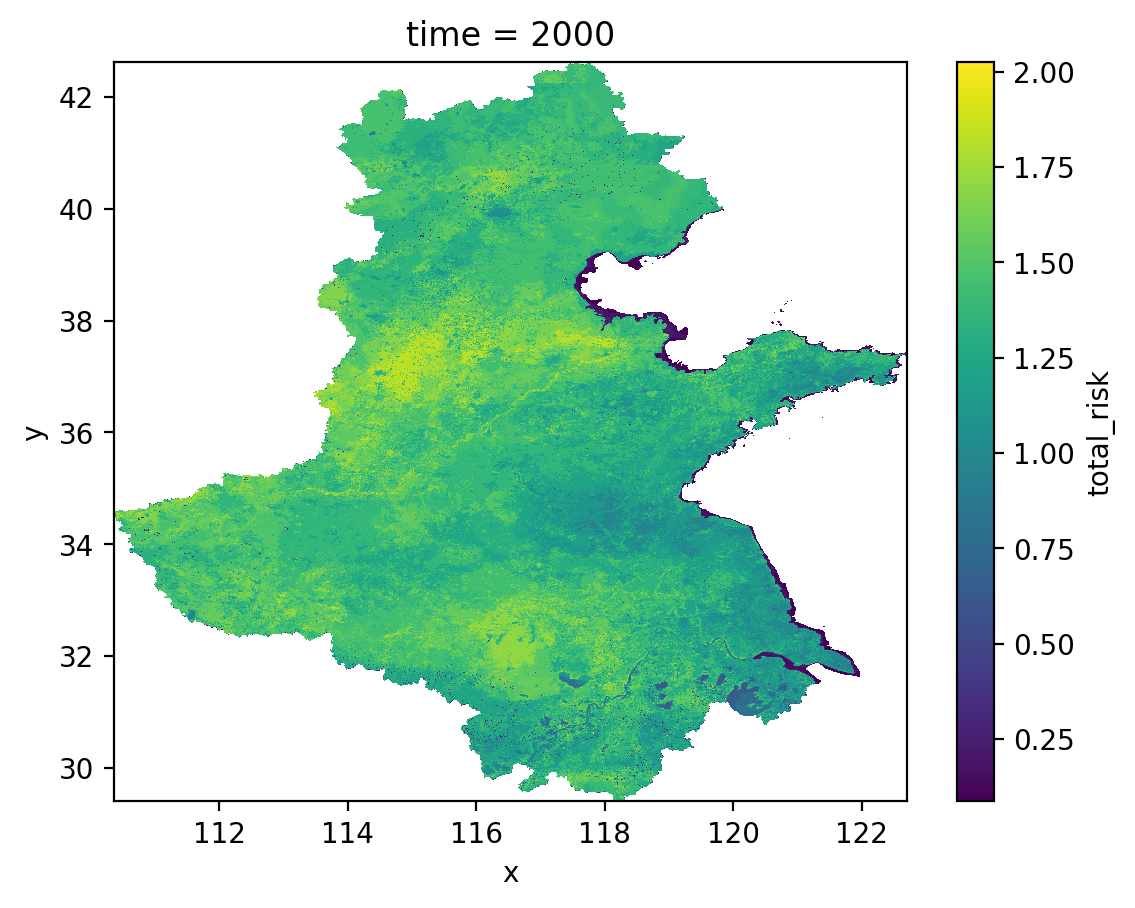

In [ ]:
total_risk_set.loc[dict(time=2000)].total_risk.plot()

In [ ]:
total_risk_set.close()

做一下高斯模糊

In [ ]:
from skimage.filters import gaussian

In [ ]:
total_risk_array_gaussian = np.empty_like(total_risk_array)
for i in range(len(total_risk_array)):
    total_risk_array_gaussian[i] = gaussian(total_risk_array[i],sigma=1)

做自然间断点分类

In [ ]:
def do_jenks(data, n_classes):
    import jenkspy
    breaks = jenkspy.jenks_breaks(data,n_classes)
    return breaks

In [ ]:
total_risk_array_gaussian_flatten = total_risk_array_gaussian[~np.isnan(total_risk_array_gaussian)].flatten()

In [62]:
total_risk_array_gaussian_iidsample = [np.random.choice(total_risk_array_gaussian_flatten,50000) for i in range(100)]

In [67]:
levels = Parallel(n_jobs=joblib.cpu_count())(delayed(do_jenks)(i,5) for i in total_risk_array_gaussian_iidsample)

In [69]:
levels = np.array(levels)
levels = np.mean(levels,axis=0)
print("final result: ",levels)
with open(r"E:\risk_evaluation\scripts\outputs\RISK_PROB\levels.txt","w") as f:
    f.write(str(levels))

final result:  [0.08618949 0.66129199 1.16013687 1.36164764 1.56321473 2.00081242]


In [56]:
total_risk_set_gaussian = xr.Dataset(
    {
        "total_risk": (["time", "y", "x"], total_risk_array_gaussian),
    },
    coords={
        "time": [i for i in range(2000,2016)],
        "y": spei_set_cutted.y.data,
        "x": spei_set_cutted.x.data,
    },
)

In [57]:
total_risk_set_gaussian.rio.write_crs("EPSG:4326",inplace=True)
total_risk_set_gaussian.rio.write_transform(inplace=True)


<xarray.Dataset>
Dimensions:      (time: 16, y: 1567, x: 1482)
Coordinates:
  * time         (time) int32 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
  * y            (y) float64 42.62 42.61 42.6 42.59 ... 29.43 29.42 29.41 29.4
  * x            (x) float64 110.4 110.4 110.4 110.4 ... 122.7 122.7 122.7 122.7
    spatial_ref  int32 0
Data variables:
    total_risk   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [58]:
total_risk_set_gaussian.to_netcdf(path=r"E:\risk_evaluation\scripts\outputs\RISK_PROB\risk_prob_gaussian.nc")

In [70]:
import py7zr
with py7zr.SevenZipFile(r"E:\risk_evaluation\scripts\outputs\RISK_PROB\risk_prob_gaussian.7z", 'w') as archive:
    archive.write(r"E:\risk_evaluation\scripts\outputs\RISK_PROB\risk_prob_gaussian.nc")
    archive.write(r"E:\risk_evaluation\scripts\outputs\RISK_PROB\levels.txt")
    archive.write(r"E:\risk_evaluation\scripts\outputs\RISK_PROB\risk_prob_gaussian.nc.aux.xml")